# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

## Original Data + GLCM + 3 Folders

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import sys, glob, time,re,string
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [3]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)


### Dataset Analysis

In [4]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [5]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


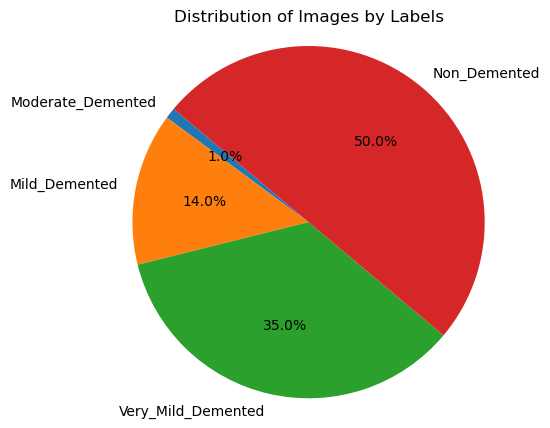

In [6]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [7]:
import shutil

source_dir = os.path.join(dataset_dir, "Mild_Demented" )
destination_dir = os.path.join(dataset_dir, "Moderate_Demented")

for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(destination_dir, file_name)
    

    shutil.move(source_file, destination_file)
os.rmdir(source_dir)

In [8]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

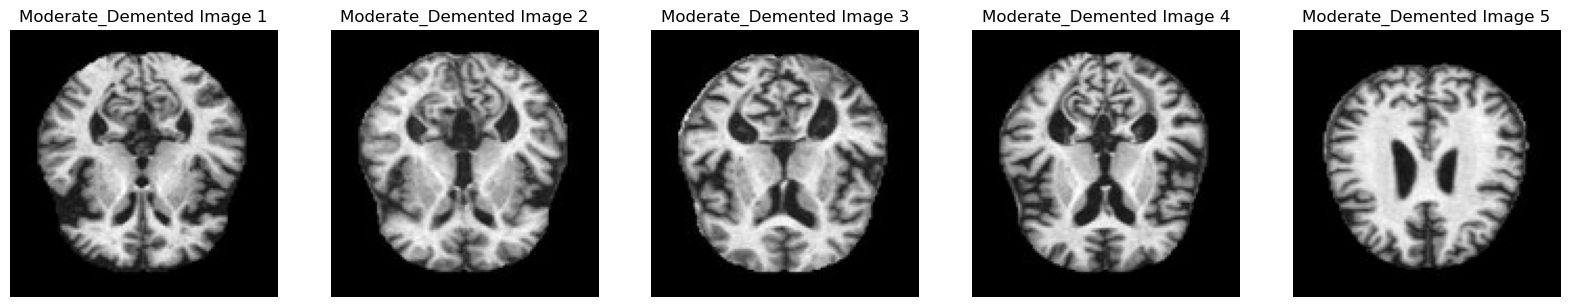

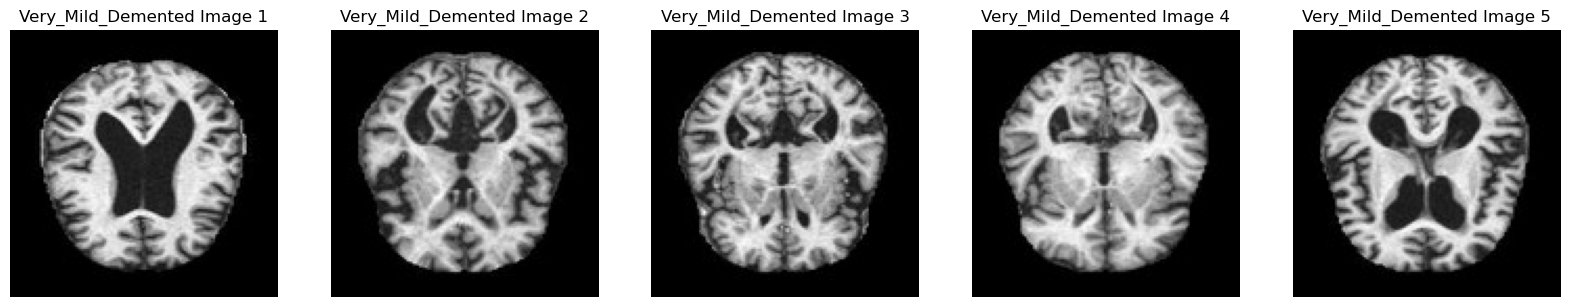

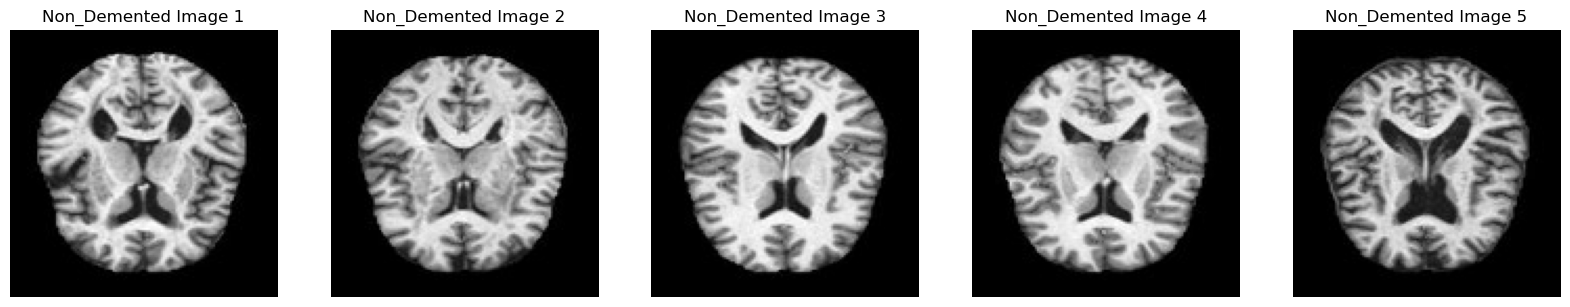

In [9]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [10]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [11]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


In [12]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 960
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


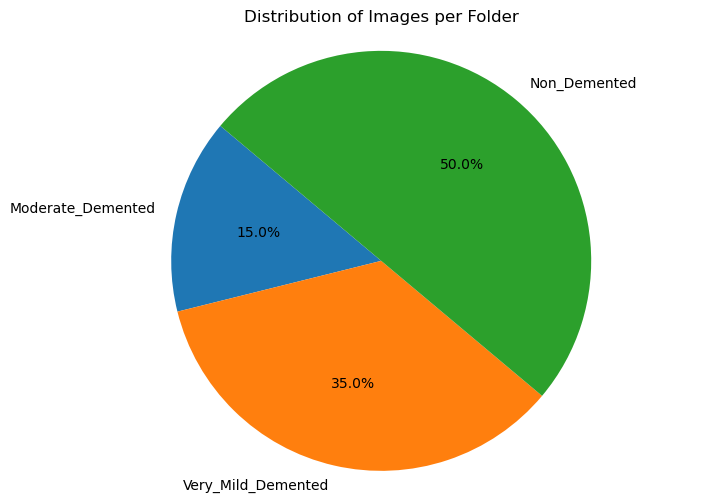

Number of Images in Each Folder:
Moderate_Demented: 960 images
Very_Mild_Demented: 2240 images
Non_Demented: 3200 images


In [13]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

In [14]:
def delete_images(label_dir, num_images):
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

dataset_dir = "./alzheimer-mri-dataset/Dataset"
non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")

num_delete_nd = 2240
num_delete_vmd = 1280

delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)


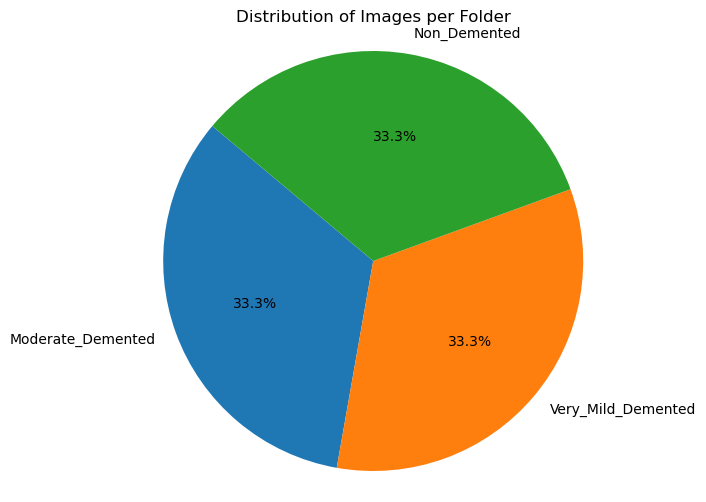

Number of Images in Each Folder:
Moderate_Demented: 960 images
Very_Mild_Demented: 960 images
Non_Demented: 960 images


In [15]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

### Grey Level Co-occurrence Matrix (GLCM)

In [17]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [18]:
dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
...,...,...
2875,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2876,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2877,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
2878,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented


In [19]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [20]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,337.737697,10.056594,0.458716,0.398331,0.976461
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,338.211491,10.050935,0.457012,0.395736,0.975792
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,230.301058,8.121555,0.469376,0.400309,0.969416
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,369.825541,10.366757,0.451688,0.390200,0.970765
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,344.594242,10.156619,0.462217,0.397934,0.970490
...,...,...,...,...,...,...,...
2875,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,317.840059,9.385458,0.471634,0.409150,0.980493
2876,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,355.366880,9.789493,0.456729,0.390447,0.974058
2877,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,272.521900,8.946358,0.458607,0.392124,0.976695
2878,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,324.593504,9.934670,0.449123,0.393315,0.976762


In [21]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,337.737697,10.056594,0.458716,0.398331,0.976461
1,338.211491,10.050935,0.457012,0.395736,0.975792
2,230.301058,8.121555,0.469376,0.400309,0.969416
3,369.825541,10.366757,0.451688,0.390200,0.970765
4,344.594242,10.156619,0.462217,0.397934,0.970490
...,...,...,...,...,...
2875,317.840059,9.385458,0.471634,0.409150,0.980493
2876,355.366880,9.789493,0.456729,0.390447,0.974058
2877,272.521900,8.946358,0.458607,0.392124,0.976695
2878,324.593504,9.934670,0.449123,0.393315,0.976762


In [22]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    accuracy = classification_report(y_test, y_pred)
    print("classification_report:", accuracy)

In [23]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10)
ml_models(rf_model, X, y)

Accuracy: 0.6111111111111112
classification_report:                     precision    recall  f1-score   support

 Moderate_Demented       0.60      0.74      0.67       203
      Non_Demented       0.71      0.65      0.68       188
Very_Mild_Demented       0.52      0.43      0.47       185

          accuracy                           0.61       576
         macro avg       0.61      0.61      0.60       576
      weighted avg       0.61      0.61      0.61       576



In [24]:
#GAUSSIAN NB
gnb_model = GaussianNB()
ml_models(gnb_model, X, y)

Accuracy: 0.4704861111111111
classification_report:                     precision    recall  f1-score   support

 Moderate_Demented       0.46      0.69      0.55       203
      Non_Demented       0.51      0.65      0.57       188
Very_Mild_Demented       0.24      0.04      0.07       185

          accuracy                           0.47       576
         macro avg       0.41      0.46      0.40       576
      weighted avg       0.41      0.47      0.41       576



In [25]:
#DECISION TREE
dt_model = DecisionTreeClassifier()
ml_models(dt_model, X, y)

Accuracy: 0.5416666666666666
classification_report:                     precision    recall  f1-score   support

 Moderate_Demented       0.59      0.53      0.56       203
      Non_Demented       0.57      0.64      0.61       188
Very_Mild_Demented       0.45      0.45      0.45       185

          accuracy                           0.54       576
         macro avg       0.54      0.54      0.54       576
      weighted avg       0.54      0.54      0.54       576



In [26]:
#SVM
svm_model = SVC(kernel='linear', random_state=42)
ml_models(svm_model, X, y)

Accuracy: 0.4322916666666667
classification_report:                     precision    recall  f1-score   support

 Moderate_Demented       0.44      0.65      0.52       203
      Non_Demented       0.46      0.53      0.49       188
Very_Mild_Demented       0.30      0.10      0.15       185

          accuracy                           0.43       576
         macro avg       0.40      0.42      0.39       576
      weighted avg       0.40      0.43      0.39       576



In [27]:
#LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ml_models(lr_model, X, y)

Accuracy: 0.4340277777777778
classification_report:                     precision    recall  f1-score   support

 Moderate_Demented       0.45      0.58      0.50       203
      Non_Demented       0.47      0.59      0.52       188
Very_Mild_Demented       0.29      0.12      0.17       185

          accuracy                           0.43       576
         macro avg       0.40      0.43      0.40       576
      weighted avg       0.40      0.43      0.40       576



In [28]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [29]:
#Train data
Images, Labels = get_images("./alzheimer-mri-dataset/Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [30]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [32]:
from collections import Counter
Counter(encoded_labels)

Counter({1: 960, 2: 960, 0: 960})

### Deep Learning

In [33]:
#Function for deep learning approaches
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=3):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [34]:
#EfficientNetB0
efficientnet_model = deep_learning(EfficientNetB0)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_eff = efficientnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 4096)              83890176  
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2

Epoch 1/100


2024-06-05 16:15:13.710707: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


72/72 [==============================] - 22s 277ms/step - loss: 1.0325 - accuracy: 0.4648 - val_loss: 0.9107 - val_accuracy: 0.5521
Epoch 2/100
72/72 [==============================] - 19s 270ms/step - loss: 0.9229 - accuracy: 0.5525 - val_loss: 0.8924 - val_accuracy: 0.5451
Epoch 3/100
72/72 [==============================] - 19s 263ms/step - loss: 0.9103 - accuracy: 0.5551 - val_loss: 0.9117 - val_accuracy: 0.5486
Epoch 4/100
72/72 [==============================] - 19s 263ms/step - loss: 0.8404 - accuracy: 0.5959 - val_loss: 0.8194 - val_accuracy: 0.6319
Epoch 5/100
72/72 [==============================] - 19s 268ms/step - loss: 0.7938 - accuracy: 0.6319 - val_loss: 0.8948 - val_accuracy: 0.5521
Epoch 6/100
72/72 [==============================] - 18s 256ms/step - loss: 0.7392 - accuracy: 0.6675 - val_loss: 0.9232 - val_accuracy: 0.5903
Epoch 7/100
72/72 [==============================] - 18s 256ms/step - loss: 0.7401 - accuracy: 0.6636 - val_loss: 0.7976 - val_accuracy: 0.6545
Epoc

In [35]:
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

18/18 [==============================] - 3s 139ms/step
F1 Score: 0.8465353889986243
Recall: 0.8506944444444444
Precision: 0.8614561611663426
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       189
           1       0.94      0.68      0.79       197
           2       0.78      0.89      0.83       190

    accuracy                           0.85       576
   macro avg       0.86      0.85      0.85       576
weighted avg       0.86      0.85      0.85       576



In [36]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_7 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 32)               

Epoch 1/100
72/72 [==============================] - 87s 1s/step - loss: 1.6544 - accuracy: 0.4861 - val_loss: 0.9029 - val_accuracy: 0.6076
Epoch 2/100
72/72 [==============================] - 82s 1s/step - loss: 0.6654 - accuracy: 0.7083 - val_loss: 0.7907 - val_accuracy: 0.6545
Epoch 3/100
72/72 [==============================] - 82s 1s/step - loss: 0.5499 - accuracy: 0.7752 - val_loss: 0.7081 - val_accuracy: 0.6997
Epoch 4/100
72/72 [==============================] - 82s 1s/step - loss: 0.3119 - accuracy: 0.8924 - val_loss: 0.5564 - val_accuracy: 0.7778
Epoch 5/100
72/72 [==============================] - 83s 1s/step - loss: 0.2023 - accuracy: 0.9384 - val_loss: 0.5932 - val_accuracy: 0.7726
Epoch 6/100
72/72 [==============================] - 81s 1s/step - loss: 0.1319 - accuracy: 0.9657 - val_loss: 0.4822 - val_accuracy: 0.8142
Epoch 7/100
72/72 [==============================] - 80s 1s/step - loss: 0.0945 - accuracy: 0.9757 - val_loss: 0.4880 - val_accuracy: 0.8160
Epoch 8/100
7

In [37]:
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

18/18 [==============================] - 16s 882ms/step
F1 Score: 0.874547774122814
Recall: 0.875
Precision: 0.8770886823904065
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       189
           1       0.91      0.81      0.85       197
           2       0.82      0.88      0.85       190

    accuracy                           0.88       576
   macro avg       0.88      0.88      0.87       576
weighted avg       0.88      0.88      0.87       576



In [38]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_13 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_14 (Dense)            (None, 256)               262400    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 32)               

Epoch 1/100
72/72 [==============================] - 57s 772ms/step - loss: 1.2172 - accuracy: 0.4735 - val_loss: 1.0381 - val_accuracy: 0.5347
Epoch 2/100
72/72 [==============================] - 54s 756ms/step - loss: 0.8892 - accuracy: 0.5877 - val_loss: 0.9190 - val_accuracy: 0.5990
Epoch 3/100
72/72 [==============================] - 57s 787ms/step - loss: 0.7473 - accuracy: 0.6628 - val_loss: 0.7822 - val_accuracy: 0.6424
Epoch 4/100
72/72 [==============================] - 56s 783ms/step - loss: 0.5978 - accuracy: 0.7435 - val_loss: 0.6864 - val_accuracy: 0.7083
Epoch 5/100
72/72 [==============================] - 55s 768ms/step - loss: 0.4538 - accuracy: 0.8207 - val_loss: 0.6334 - val_accuracy: 0.7587
Epoch 6/100
72/72 [==============================] - 59s 820ms/step - loss: 0.3656 - accuracy: 0.8611 - val_loss: 0.7155 - val_accuracy: 0.7274
Epoch 7/100
72/72 [==============================] - 56s 779ms/step - loss: 0.2825 - accuracy: 0.8945 - val_loss: 0.5678 - val_accuracy:

In [39]:
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))

18/18 [==============================] - 7s 346ms/step
F1 Score: 0.8366971032745592
Recall: 0.8385416666666666
Precision: 0.8370639158132754
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       189
           1       0.83      0.77      0.80       197
           2       0.81      0.79      0.80       190

    accuracy                           0.84       576
   macro avg       0.84      0.84      0.84       576
weighted avg       0.84      0.84      0.84       576

